# Executor for StyleGAN on Fishtank

Fishtank is Gagan's pc, runs in tensorflow 1.15 conda env.

In [1]:
import os
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import pretrained_networks

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
tflib.init_tf()

In [4]:
network = 'stylegan2_256x256_balanced.pkl'
network_dir = '../'
network = os.path.join(network_dir, network)

In [5]:
if os.path.isfile(network):
    print("Network found, calling load network...")
    _G, _D, Gs = pretrained_networks.load_networks(network)
else:
    print("network not found at: ", network)
    print("In that directory there is: ")
    print(os.listdir(network_dir))

Network found, calling load network...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.


In [6]:
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=8)

In [7]:
def make_latents(Gs, seed=0, sigma = 1.0, mu = 0.0):
    latents =  sigma * np.random.RandomState(seed).randn(1, Gs.input_shape[1]) + mu
    return latents

In [8]:
make_latents(Gs).shape

(1, 512)

In [9]:
images = Gs.run(make_latents(Gs), None, **synthesis_kwargs) # [seed, y, x, rgb]

In [10]:
images.shape

(1, 256, 256, 3)

In [11]:
def plot_image(Gs_output):
    image = PIL.Image.fromarray(Gs_output[0], 'RGB')
    plt.imshow(image)

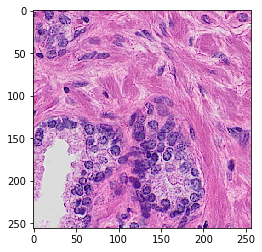

In [12]:
plot_image(images)

## StyleGAN Network Details

In [13]:
Gs.input_shape

[None, 512]

In [14]:
Gs.print_layers()


Gs                            Params    OutputShape         WeightShape     
---                           ---       ---                 ---             
latents_in                    -         (?, 512)            -               
labels_in                     -         (?, 0)              -               
lod                           -         ()                  -               
dlatent_avg                   -         (512,)              -               
G_mapping/latents_in          -         (?, 512)            -               
G_mapping/labels_in           -         (?, 0)              -               
G_mapping/Normalize           -         (?, 512)            -               
G_mapping/Dense0              262656    (?, 512)            (512, 512)      
G_mapping/Dense1              262656    (?, 512)            (512, 512)      
G_mapping/Dense2              262656    (?, 512)            (512, 512)      
G_mapping/Dense3              262656    (?, 512)            (512, 512)     

## Slerp?
reference: https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/

In [34]:
# reference: https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/
# example of interpolating between generated faces

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input
 
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
	# interpolate ratios between the points
	ratios = np.linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return np.asarray(vectors)

In [18]:
input_dimensionality = 512

In [19]:
pts = generate_latent_points(input_dimensionality, 2)

In [24]:
pts.shape # two points, shape len

(2, 512)

In [21]:
interpolated = interpolate_points(pts[0], pts[1])

In [23]:
interpolated.shape # 10 points, shape len

(10, 512)

In [25]:
images = Gs.run(interpolated, None, **synthesis_kwargs) # [seed, y, x, rgb]

In [27]:
images.shape

(10, 256, 256, 3)

In [35]:
from mpl_toolkits.axes_grid1 import ImageGrid

In [57]:
def plot_grid(images_sg2_output):
    imgs = images_sg2_output
    num = len(imgs)
    num_cols = 3
    num_rows = (num // num_cols) + (num % num_cols)
    fig = plt.figure(figsize=(20,20))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(num_rows, num_cols),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )
    for idx,(ax, im) in enumerate(zip(grid, imgs)):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_title(idx)
    plt.show()

In [62]:
def plot_pair(one,two):
    plot_grid((one,two))

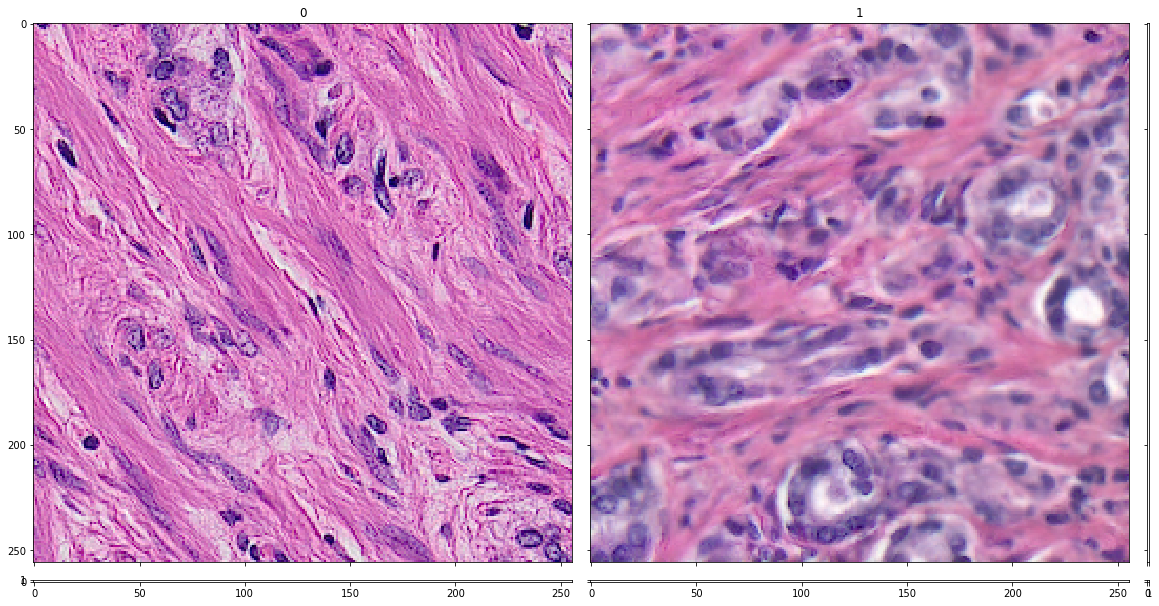

In [63]:
plot_pair(images[0],images[len(images)-1])

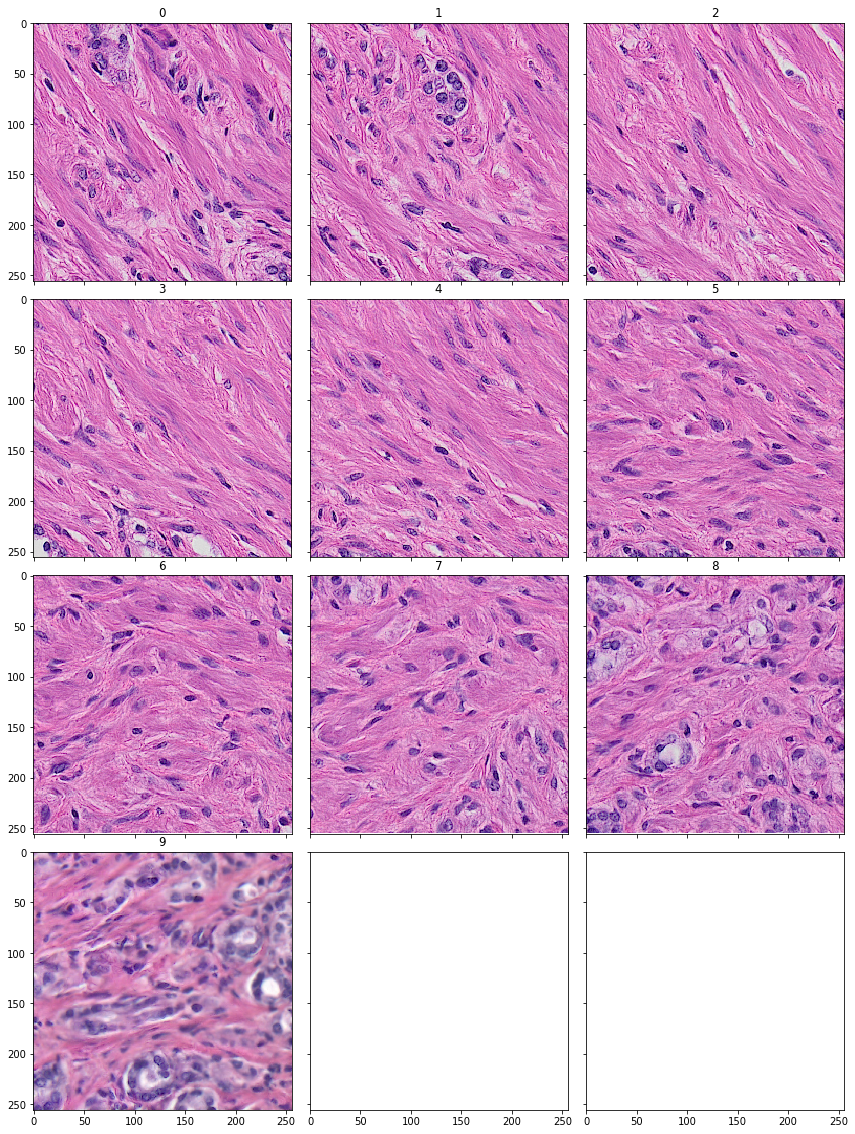

In [58]:
plot_grid(images)